# Home Value Prediction

## Project Goals
* Identify key features that can be used to create an effective predictive model.
* Use regression models to make house price predictions.
* Use findings to make recommendations and establish a foundation for future work to improve model's performance.

## Imports

In [1]:
#list all of the imports I used in this notebook or in a module
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")
from importlib import reload


#import my personal modules created for this report
import wrangle as w
import explore as e
import model as m

## Acquire

* Data acquired from the Codeup mySQL server on November 16, 2022
* It contained 52,441 rows and 6 columns
* Each observation represents a single-family home
* Each column represents a feature of those homes

In [2]:
#import unclean data from Codeup mySQL server
zillow_unclean = w.acquire_zillow_data()

## Prepare

#### Dropped rows:
* Duplicates   
* Rows where ```bedrooms``` == 0 AND ```bathrooms``` == 0
* Rows where ```square_feet``` >= 10,000  (because these are large and can skew the data)
* Rows where ```home_value``` >= 1,600,000 (because these values are large and can skew the data)
* Rows containing null values in any column

#### Created features
* ```county``` (names based on the fips code):  
    - 6037: LA
    - 6059: Orange 
    - 6111: Ventura 
* ```bath_bed_ratio``` 
    - Column displaying bathrooms/bedrooms
* ```2017_age```
    - Column diplaying age of house in 2017 (2017-year_built)

#### Other prep
* Split data into train, validate, and test (65/20/15)

In [3]:
#clean data
zillow = w.clean_zillow(zillow_unclean)
#split data
train, validate, test = w.split_data(zillow)

### Data dictionary
| Feature | Definition | Type |
|:--------|:-----------|:-------
|**parcelid**| Definition| *int*|
| **bathroooms** | The number of bathrooms in the home. |*float*|
| **bedrooms** | The number of bedrooms in the home.|*int*|
|**square_feet**| Square footage of the house| *int*|
|**year_built**| Year the house was built| *int*|
|**bath_bed_ratio**| The number of bathrooms divided by number of bedrooms| *float*|
|**county**| Name of the county where the house is located| *string*|
|**2017_age**| Age of the house in 2017 (when the data was collected| *int*|
|**Target variable**
|**home_value**| The tax-assessed value of the home. | *float* |

### A look at the data

In [4]:
#show the first few rows of the train data
train.head()

,parcelid,bathrooms,bedrooms,home_value,square_feet,year_built,bath_bed_ratio,county,2017_age
43055,13955676,2.5,3,467000.0,1509,2001,0.833333,Orange,16
27580,14184733,3.0,5,411581.0,2822,1993,0.600000,Orange,24
38642,10889898,1.0,2,156917.0,878,1940,0.500000,LA,77
40986,12579090,2.0,4,264953.0,1620,1964,0.500000,LA,53
37881,12919161,2.0,4,402200.0,1128,1955,0.500000,LA,62


## Explore

### 1. Is there a significant relationship between square footage and home value?

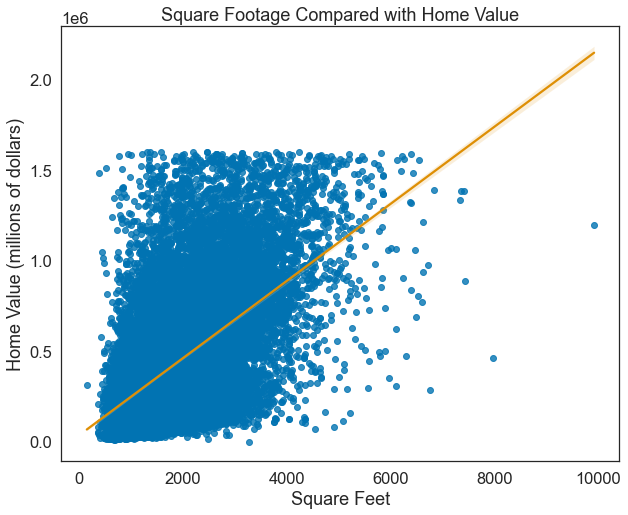

In [5]:
#show comparison of square feet with home value
e.square_feet_viz(train)

**It looks like there might be a relationship between square feet and home value**

**Set Hypothesis**

$H_0$ = There is no linear correlation between square feet and home value 

$H_a$ = There is a linear correlation between square feet and home value 

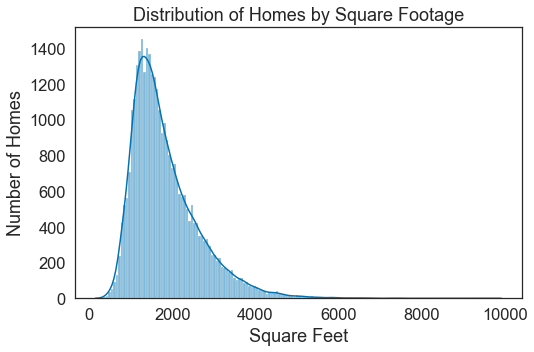

In [6]:
#show distribution of homes by square footage
e.sq_feet_home_distribution(train)

**There is a skewed distribution so I will use the Spearman's R test**

In [7]:
#run spearman test and show results
e.sq_feet_spearmanr(train)

Correlation Coefficient: 0.48
p-value: 0.0


**p < alpha, so we can reject the null hypothesis and say there is probably a a linear correlation between square feet and home value, but not a very strong one.** 

### 2. Is there a significant relationship between the bath-to-bed ratio and home value? 

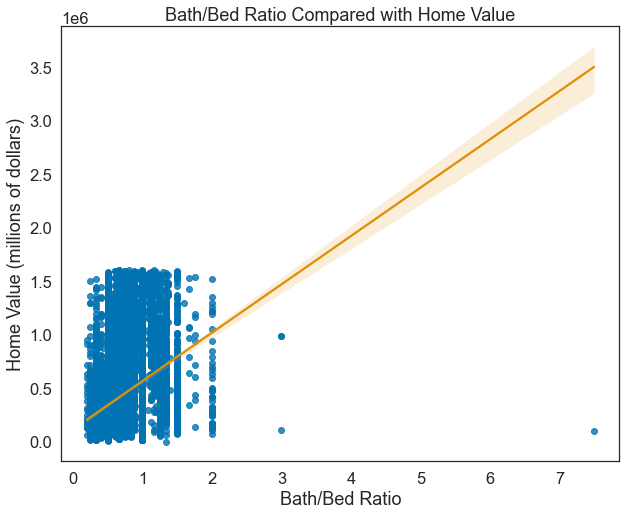

In [8]:
#show comparison of bath/bed ratio and home value
e.bath_bed_viz(train)

**It looks like there is a linear correlation between bath_bed_ratio and home value *AND a pesky outlier***

**Set Hypothesis**

$H_0$ = There is no linear correlation between bath_bed_ratio and home value 

$H_a$ = There is a linear correlation between bath_bed_ratio and home value 

In [9]:
#run spearman test and show results
e.bath_bed_ratio_spearmanr(train)

Correlation Coefficient: 0.32
p-value: 0.0


**p < alpha, so we can reject the null hypothesis and say there is probably a a linear correlation between bath_bed_ratio and home value.** 

## 3. Does location have a relationship with home value?

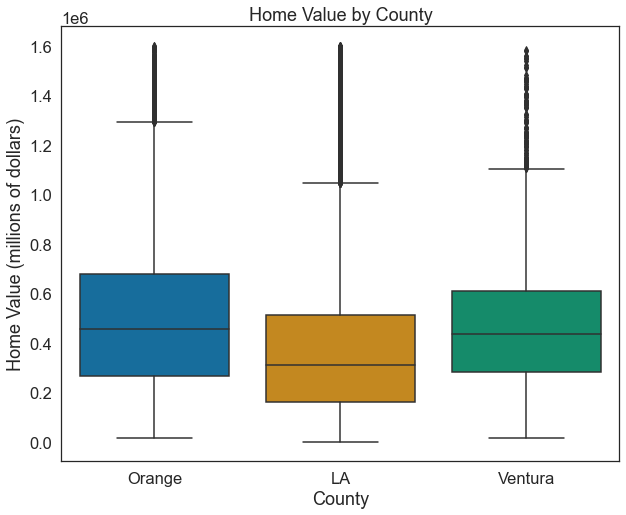

In [10]:
#show home value across the three counties
e.county_viz(train)

**It looks like there is a difference in home values in each county.**

$H_0$ = Average home values of those in LA county, Orange county and Ventura county are the same.

$H_a$ = Average home values of those in LA county, Orange county and Ventura county are not the same.

In [11]:
#run ANOVA and show results
e.county_ANOVA(train)

F-score: 495.59484
p-value: 9.732e-213


**Since p < alpha we can reject the null hypothesis and say Average home values of those in LA county, Orange county and Ventura county are not the same.**

## 4. Is there a significant relationship between age of the home and home value?

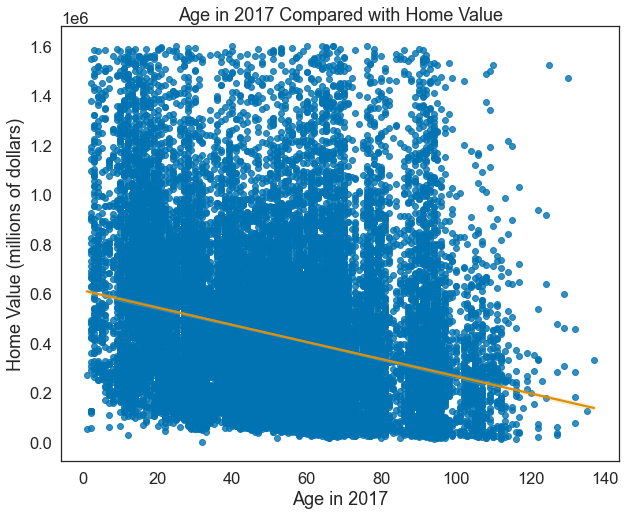

In [12]:
#show age compared with home value
e.age_viz(train)

**It looks like there is a linear correlation between 2017_age and home value**

**Set Hypothesis**

$H_0$ = There is no linear correlation between 2017_age and home value 

$H_a$ = There is a linear correlation between 2017_age and home value 

In [13]:
#run spearmanr test and show results
e.age_spearmanr(train)

Correlation Coefficient: -0.26876814
p-value: 0.0


**p < alpha, so we can reject the null hypothesis and say there is probably a a linear correlation between 2017_age and home value.** 

### Exploration Summary
* ```square_feet``` has the highest correlation coefficient so I will use it in my model.
* ```bed_bath_ratio```, ```2017_age```, and ```county``` all show a relationship with home value so I will also take them to my model.

### Features I'm moving on with
| Feature | Reason | 
|:--------|:-----------|
|**square_feet**| From our Spearman's R test we saw that there is a 0.48 correlation between ```square_feet``` and ```home_value```|
|**bath_bed_ratio**| From our Spearman's R test we saw that there is a 0.32 correlation between ```bath_bed_ratio``` and ```home_value```|
|**2017_age**| From our Pearson's R test we saw that there is a 0.32 correlation between ```2017_age``` and ```home_value```|
|**county**| From our ANOVA test we see that there is a difference between the home values in each county|

In [14]:
#save drivers into a list
drivers = ['square_feet', 'bath_bed_ratio', '2017_age', 'county']

### Features I'm not moving on with

| Feature | Reason 
|:--------|:-----------
|**parcelid**| id number that is not needed in the model
| **bathroooms** | Represented in the ```bath_bed_ratio``` so it would be redundant.
| **bedrooms** | Represented in the ```bath_bed_ratio``` so it would be redundant.
|**year_built**| Represented in the ```2017_age``` so it would be redundant.

# Modeling

### Prep for modeling
* I scaled the drivers using the minmax scaler
* Split the data into where ```home_value``` is the target variable

In [15]:
#prepare data for modeling
X_train, y_train, X_validate, y_validate, X_test, y_test = w.prep_for_model(train, validate, test, 'home_value', drivers)

### Baseline models
* Looked at both using mean and median as a baseline model.
* Mean baseline performed better on the in-sample and out-of sample data SO I went with mean.

In [16]:
#run baseline models mean and median
m.baseline_models(y_train, y_validate)

,model,RMSE_train,RMSE_validate,Difference
0,mean_baseline,313878.807820,312799.264162,1079.543658
1,median_baseline,320546.288486,319026.131853,1520.156633


### Model Comparison

In [17]:
#run and compare models
m.regression_models(X_train, y_train, X_validate, y_validate)

,model,RMSE_train,r^2_train,RMSE_validate,r^2_validate
0,OLS Regressor,258979.286048,0.319221,255023.466108,0.335266
1,Lasso_alpha_1,258979.859230,0.319218,255020.856580,0.335280
2,GLM,266071.034814,0.281426,264905.702635,0.282763
3,Quadratic,252612.889098,0.352280,248837.686557,0.367126


### Comparing Models
* All models perfomed better than baseline for both train and validate data.
* It was interesting that OLS Regressor and Lasso Lars both performed better on the out-of-sample data.

### Best model: Random Forest Model 
* I chose the quadratic model (linear regression with polynomial features) because the difference in $r^2 score$ between the train and validate was around 1% and they were both higher than the other models
* I will now run the that model on test data to gauge how it will perform on future data

In [18]:
m.best_model(X_train, y_train, X_validate, y_validate, X_test, y_test)

,model,RMSE_train,r^2_train,RMSE_validate,r^2_validate,RMSE_test,r^2_test
0,Quadratic,252612.889098,0.35228,248837.686557,0.367126,251598.306307,0.353342


**This model performs better than baseline and with very similar accuracy across all three data sets (train, validate and test).**

## Conclusion

### Summary
* ```square_feet``` seems to be a driver of home value
* ```bath_bed_ratio``` seems to be a driver of home value
* ```county``` seems to be a driver of home value
* ```2017_age``` seems to be a driver of home value


### Recommendations
* We should do more research of the areas where these houses are located to have a better understanding of how location is driving home value.
* Dive into our data and see what information has been corrupted and delete those rows so that we can make sure we are using as accurate data as we can.

### Next Steps
* In the next iteration:
    * Look into neighborhoods, and exact location of the houses to see if that will help the model perform better.
    * Look into other features of the house (garage, pool, deck, etc.) to see if they are also drivers of home value.